We construct rolling (24hr,1 week) * (maxTemp,temp HDD ,temp CDD) features in the dataset. We remove features that aren't present in the weather forecast data (as of Sept 18), because the dropped features aren't high up in the feature importance of previously trained xgboost model and/or have high correlation with temperature, and because we want to be able to make predictions on forecast data by training on historical data.

We will only use the following columns : cloud cover(% out of 100), dewpoint (°F), temperature (°F), wind direction (radial angle out of °360), wind speed (miles per h, same as historical)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# to be generalized later
MODEL_HOUR = 7

In [3]:
#load data/AllWeathDTypes_NWPP_10yrs.csv as a dataframe
DFX = pd.read_csv("../data/WFC_RNWPP_22Aug25-20Sep25.csv")
DFXhist = pd.read_csv("../data/AllWeath_regNWPP_2021-2025.csv")
#find min 'datetime
#subtract 7 hours from datetime to convert from UTC to PST
DFX = DFX[DFX['model_hour'] == MODEL_HOUR].drop(columns=['model_hour'])
DFX.rename(columns={'temp':'temperature','cloud_cover':'cloudCover','winddir':'windDirection','windspeed_mph':'windSpeed'}, inplace=True)
DFX['datetime'] = pd.to_datetime(DFX['datetime'])
DFX['model_date'] = pd.to_datetime(DFX['model_date'])
DFX['source'] = 'forecast'
DFXhist['datetime'] = pd.to_datetime(DFXhist['datetime'])

#for every unique model_date, append data from DFXhist['station_name','model_date','datetime','cloudCover','dewpoint','temperature','windDirection','windSpeed'] where datetime is between model_date-7 days and model_date-1 day, set model_date of appended data to model_date of DFX data. add another column 'source' to DFX and appended data, which is the either 'forecast' or 'historical'
for model_date in DFX['model_date'].unique():
    mask = (DFXhist['datetime'] >= (model_date - pd.Timedelta(days=7))) & (DFXhist['datetime'] < model_date)
    temp_df = DFXhist.loc[mask, ['station_name','datetime','cloudCover','dewpoint','temperature','windDirection','windSpeed']].copy()
    temp_df['model_date'] = model_date
    temp_df['source'] = 'historical'
    #append temp_df to DFX
    DFX = pd.concat([DFX, temp_df], ignore_index=True)
# station_utc_offset = {"Tacoma": 7, "Boise": 6, "Eugene": 7, "Portland": 7, "NWPP": 7, "Vancouver": 7, "Yakima": 7, "Pendleton": 7, "Billings": 6, "Medford": 7,
#     "Reno": 7, "Salt Lake City": 6, "Great Falls": 6, "Klamath Falls": 7, "Spokane": 7, "Seattle": 7}

# if set(DFX['station_name'].unique()) != set(station_utc_offset.keys()):
#     raise ValueError("Station names in DFX do not match keys in station_utc_offset!")
# DFX['datetime'] = DFX.apply(lambda row: row['datetime'] - pd.Timedelta(hours=station_utc_offset.get(row['station_name'],7)), axis=1)
DFX = DFX[DFX['temperature'] >= 0]

In [4]:
DFX = DFX.set_index(['station_name','model_date','datetime']).sort_values(by=['station_name','model_date','datetime'])

In [5]:
# Calculate temperature difference from 65°F
DFX['temp_diff'] = DFX['temperature'] - 65
DFX['temp_cdd'] = DFX['temp_diff'].clip(lower=0)  # For CDD: positive differences
DFX['temp_hdd'] = DFX['temp_diff'].clip(upper=0).abs()  # For HDD: absolute negative differences
DFX['temp_diff'] = DFX['temp_diff'].abs()
# Calculate rolling statistics with time-based windows (using closed='left' to exclude current hour)
DFX['24hrMaxTempDelt'] = DFX.groupby(level=[0,1])['temp_diff'].rolling('24H', on=DFX.index.get_level_values(2), closed='left').max().reset_index(level=[0,1], drop=True)
DFX['1WMaxTempDelt'] = DFX.groupby(level=[0,1])['temp_diff'].rolling('7D', on=DFX.index.get_level_values(2), closed='left').max().reset_index(level=[0,1], drop=True)

DFX['24hrTempCDD'] = DFX.groupby(level=[0,1])['temp_cdd'].rolling('24H', on=DFX.index.get_level_values(2), closed='left').sum().reset_index(level=[0,1], drop=True)
DFX['24hrTempHDD'] = DFX.groupby(level=[0,1])['temp_hdd'].rolling('24H', on=DFX.index.get_level_values(2), closed='left').sum().reset_index(level=[0,1], drop=True)
DFX['1WTempCDD'] = DFX.groupby(level=[0,1])['temp_cdd'].rolling('7D', on=DFX.index.get_level_values(2), closed='left').sum().reset_index(level=[0,1], drop=True)
DFX['1WTempHDD'] = DFX.groupby(level=[0,1])['temp_hdd'].rolling('7D', on=DFX.index.get_level_values(2), closed='left').sum().reset_index(level=[0,1], drop=True)

C:\Users\kumar\AppData\Local\Temp\ipykernel_24808\2066778436.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  DFX['24hrMaxTempDelt'] = DFX.groupby(level=[0,1])['temp_diff'].rolling('24H', on=DFX.index.get_level_values(2), closed='left').max().reset_index(level=[0,1], drop=True)
C:\Users\kumar\AppData\Local\Temp\ipykernel_24808\2066778436.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  DFX['24hrTempCDD'] = DFX.groupby(level=[0,1])['temp_cdd'].rolling('24H', on=DFX.index.get_level_values(2), closed='left').sum().reset_index(level=[0,1], drop=True)
C:\Users\kumar\AppData\Local\Temp\ipykernel_24808\2066778436.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  DFX['24hrTempHDD'] = DFX.groupby(level=[0,1])['temp_hdd'].rolling('24H', on=DFX.index.get_level_values(2), closed='left').sum().reset_index(level=[0,1], drop=True)


In [6]:
DFX=DFX[DFX['source']=='forecast'].drop(['feelsliketemp','feelsliketempdiff','ghirradiance','precip','tempdiff','tempnormal','temp_diff', 'temp_cdd', 'temp_hdd','source'], axis=1).reset_index()[['station_name','model_date','datetime','cloudCover','dewpoint','temperature','windDirection','windSpeed','24hrMaxTempDelt','1WMaxTempDelt','24hrTempCDD','24hrTempHDD','1WTempCDD','1WTempHDD']]

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)  # Increase width as needed
print(DFX[(DFX['station_name']=='Billings')&(DFX['model_date'] == '2025-09-04')][['datetime','temperature','24hrMaxTemp','1WMaxTemp','24hrTempCDD','24hrTempHDD','1WTempCDD','1WTempHDD']].head(90))

                datetime  temperature  24hrMaxTemp  1WMaxTemp  24hrTempCDD  24hrTempHDD  1WTempCDD  1WTempHDD
4320 2025-09-04 00:00:00        62.96        80.00       91.0        72.00        65.00    1058.00     265.00
4321 2025-09-04 01:00:00        64.94        80.00       91.0        67.00        67.04    1057.00     267.04
4322 2025-09-04 02:00:00        64.04        80.00       91.0        65.00        67.10    1057.00     266.10
4323 2025-09-04 03:00:00        64.94        80.00       91.0        65.00        67.06    1057.00     266.06
4324 2025-09-04 04:00:00        62.06        80.00       91.0        65.00        63.12    1057.00     265.12
4325 2025-09-04 05:00:00        61.26        80.00       91.0        65.00        60.06    1057.00     266.06
4326 2025-09-04 06:00:00        60.47        80.00       91.0        65.00        55.80    1057.00     268.80
4327 2025-09-04 07:00:00        58.92        80.00       91.0        65.00        49.33    1057.00     271.33
4328 2025-

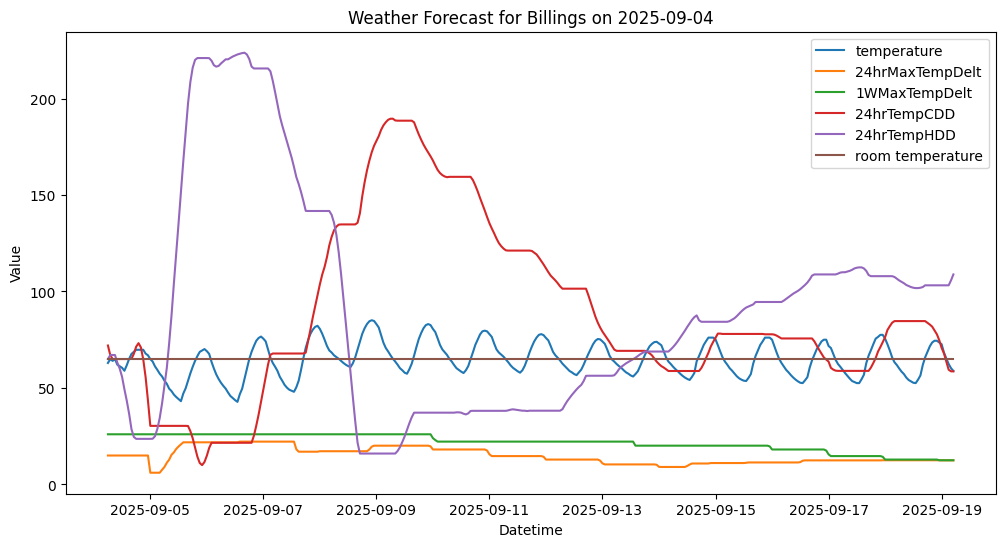

In [8]:
#plot the columns of DFX[(DFX['station_name']=='Billings')&(DFX['model_date'] == '2025-09-04')][['temperature','24hrMaxTemp','1WMaxTemp','24hrTempCDD','24hrTempHDD','1WTempCDD','1WTempHDD']] vs 'datetime'
import matplotlib.pyplot as plt

billings_data = DFX[(DFX['station_name']=='Billings')&(DFX['model_date'] == '2025-09-04')]
plt.figure(figsize=(12,6))
for column in ['temperature','24hrMaxTempDelt','1WMaxTempDelt','24hrTempCDD','24hrTempHDD']:  #,'1WTempCDD','1WTempHDD'
    plt.plot(billings_data['datetime'], billings_data[column], label=column)
plt.plot(billings_data['datetime'], 65*np.ones(len(billings_data['datetime'])), label='room temperature')  # Plot temperature points
plt.title('Weather Forecast for Billings on 2025-09-04')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.show()

In [9]:
DFX.to_csv("../data/FE_WFC_R-NWPP_H-7_22Aug25-20Sep25.csv", index=False)